### To determine the contents of a file:

In [168]:
# imports
%matplotlib inline
import os
import pandas as pd
import numpy as np #import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022 
import scipy

import sys
#maybe need to do this in case I change the path at the end for saving elsewhere?
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")

import ftir.modeling.peak_fitting as peak_fitting
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import create_fit_singleplot #added this to avoid additional layer of subplotting of residuals
# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
from ftir.io.utils import create_df_from_single_file
# import ftir.modeling.peak_definitions 
#from ftir.modeling.peak_definitions import four_peak

import math
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.spatial import ConvexHull

import time
import tkinter as tk
from tkinter import *
from tkinter import filedialog

import seaborn as sns

import opusFC

f = r"C:\Users\jrosh\Box\FTIR\Structural Mapping\8.4.2022CoffeeRing\Attempt2.0"
dbs = opusFC.listContents(f)
print(dbs)
dbs[1]

[('AB', '3D', 'NONE'), ('SSC', '3D', 'NONE'), ('RSC', '2D', 'NONE'), ('TRC', '3D', 'NONE')]


('SSC', '3D', 'NONE')

### Load the first datablock in dbs: 

In [169]:
data = opusFC.getOpusData(f, dbs[1])
data.regions

[Region 1 (9 x 3), Region 2 (5 x 3)]

In [170]:
data.regions[1].mapX[:]

array([ 6676.22021484, 10539.06738281, 14401.9140625 , 18264.76171875,
       22127.609375  ,  6676.22021484, 10539.06738281, 14401.9140625 ,
       18264.76171875, 22127.609375  ,  6676.22021484, 10539.06738281,
       14401.9140625 , 18264.76171875, 22127.609375  ])

#####This is the money part: extracting x and y data

In [171]:
#make a dictionary of x-y location data
list_of_regions=[]
x_coordinates = []
y_coordinates = []
for j in range(len(data.regions)):

    x_coordinates = np.append(x_coordinates, data.regions[j].mapX[:])
    y_coordinates = np.append(y_coordinates, data.regions[j].mapY[:])
    for i in range(len(data.regions[j].mapX)):

        list_of_regions.append(j+1) #data.regions[j].split())
        
    #list_of_regions = i in range(len(data.regions[j].mapX))
#xydict = {'region':list_of_regions,'x_coordinate':data.regions[0].mapX[:],'y coordinate':data.regions[0].mapY[:]}#,data.x:data.regions[0].spectra[:]}
xydict = {'region':list_of_regions,'x coordinate':x_coordinates,'y coordinate':y_coordinates}#,data.x:data.regions[0].spectra[:]}
len(list_of_regions)


42

In [172]:
#Make a loop or use a fancy 1 liner to take all of the X and Y data from here and then put it in a dataframe as the first 2 rows, or maybe the 2nd and 3rd rows 
# (probably best to have name/title of column, then x, then y, then data)
xypositions_df = pd.DataFrame(data=xydict)#[data.regions[0].mapX[:],data.regions[0].mapY[:]])
xypositions_df.head(5)

,region,x coordinate,y coordinate
0,1,5603.669922,2015.540039
1,1,5702.126465,2015.540039
2,1,5800.583008,2015.540039
3,1,5899.039551,2015.540039
4,1,5997.496094,2015.540039


In [173]:
type(data.regions[0].spectra[:])

numpy.ndarray

In [174]:
#make dataframe of actual spectra, multiple regions
spectra_df = pd.DataFrame()
print('data regions len:' ,len(data.regions))
for i in range(len(data.regions)): 
  #  print(data.regions[i].spectra[:])
    spectra_df = pd.concat([spectra_df,pd.DataFrame(data.regions[i].spectra[:])])
#data.regions[].spectra[:]
spectra_df

tspectra_df =spectra_df.transpose()
#spectra_df
labeledspectra_df = tspectra_df.set_index(data.x)#what does drop do here? seemingly nothing
#spectra_df['wavenumber'] = data.x

tlabeledspectra_df = labeledspectra_df.transpose()
tlabeledspectra_df.index = tlabeledspectra_df.index.set_names(['Index within Region'])
tlabeledspectra_df = tlabeledspectra_df.reset_index(col_fill="index for region")
#tlabeledspectra_df
#spectra_df

data regions len: 2


In [175]:
data.x
wavenumber_df = pd.DataFrame(data.x)
wavenumber_df.iloc[2]

0    3995.660329
Name: 2, dtype: float64

In [176]:
# wavenumbers = []

# for i in range(len(data.regions[0].spectra[:])):
#     for j in range(len(data.regions[0].spectra[:])):
#         wavenumbers.append(data.regions[0].spectra[:][i][j])
# length_wavenumbers =len(wavenumbers)
# length_wavenumbers
# #len(data.regions[0].spectra[:][:][:])
# wavenumbers


In [211]:
#Make a df with all info (region number, x&y coordinates, index within region, and then intensity for all wavenumbers)
twodfs = [xypositions_df, tlabeledspectra_df]

complete_df = pd.concat(twodfs, axis=1,join='inner')
#complete_df
#complete_df[complete_df["region"]>1]
complete_df.transpose().iloc[4:]

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
3998.516413,0.450608,0.443068,0.436386,0.458521,0.449343,0.434332,0.433498,0.435922,0.456240,0.459336,...,0.455777,0.464051,0.455591,0.458224,0.456177,0.459080,0.465324,0.459310,0.458835,0.459541
3997.088371,0.446442,0.438975,0.432401,0.454302,0.445209,0.430282,0.429501,0.431825,0.452050,0.455137,...,0.451604,0.459766,0.451365,0.454004,0.451992,0.454824,0.461050,0.455140,0.454635,0.455295
3995.660329,0.442394,0.434961,0.428464,0.450143,0.441152,0.426328,0.425583,0.427808,0.447908,0.451004,...,0.447480,0.455545,0.447216,0.449857,0.447889,0.450613,0.456882,0.451006,0.450495,0.451112
3994.232288,0.440009,0.432567,0.426071,0.447644,0.438764,0.423978,0.423232,0.425432,0.445420,0.448514,...,0.444981,0.453023,0.444736,0.447402,0.445429,0.448097,0.454388,0.448514,0.447999,0.448621
3992.804246,0.438879,0.431418,0.424868,0.446430,0.437657,0.422858,0.422078,0.424333,0.444223,0.447267,...,0.443750,0.451804,0.443547,0.446242,0.444207,0.446917,0.453138,0.447303,0.446780,0.447443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605.489628,0.042236,0.042017,0.043788,0.044763,0.049353,0.050730,0.050925,0.051066,0.049314,0.041067,...,0.043089,0.040289,0.044367,0.043387,0.042310,0.042304,0.041011,0.046232,0.046842,0.047420
604.061587,0.040423,0.040136,0.041849,0.042726,0.047119,0.048424,0.048610,0.048806,0.047139,0.039228,...,0.041091,0.038334,0.042353,0.041378,0.040387,0.040311,0.039072,0.044089,0.044717,0.045230
602.633545,0.038270,0.037961,0.039701,0.040460,0.044671,0.045822,0.046036,0.046219,0.044669,0.037146,...,0.038883,0.036161,0.040070,0.039137,0.038203,0.038060,0.036903,0.041691,0.042315,0.042829
601.205503,0.035896,0.035612,0.037402,0.038052,0.042057,0.043046,0.043297,0.043448,0.042012,0.034920,...,0.036546,0.033865,0.037642,0.036787,0.035853,0.035674,0.034589,0.039175,0.039732,0.040278


In [256]:
#Maybe it's best to do some math, then to transpose back the matrix and then add on x and y data and remove any issues with the index?
complete_transposed_wavenumberfirstcolumn_df = complete_df.transpose().iloc[4:]
complete_transposed_wavenumberfirstcolumn_df = complete_transposed_wavenumberfirstcolumn_df.reset_index()
#complete_transposed_wavenumberfirstcolumn_df.head(4)
#len(complete_transposed_wavenumberfirstcolumn_df.transpose())
#list_of_columns = [1:] 
sd_baseline_correction(complete_transposed_wavenumberfirstcolumn_df, cols = list(range(len(complete_df))),flip=False, method='rubberband', bounds=(1715, 1595),freq='Index')

,index,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,41
0,1713.649891,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1712.221850,0.147003,0.146105,0.144291,0.151140,0.151610,0.148444,0.148323,0.148632,0.152276,...,0.150145,0.149784,0.150519,0.150387,0.150140,0.150709,0.150482,0.152317,0.152370,0.152832
2,1710.793808,0.229365,0.228173,0.225449,0.236301,0.237293,0.232409,0.232190,0.232619,0.238258,...,0.234553,0.233624,0.235078,0.234747,0.234391,0.235313,0.234735,0.238092,0.238263,0.239010
3,1709.365766,0.232356,0.231416,0.228758,0.239939,0.241236,0.236306,0.236070,0.236437,0.242102,...,0.237987,0.236655,0.238419,0.237962,0.237640,0.238611,0.237781,0.241731,0.241980,0.242780
4,1707.937725,0.178187,0.177802,0.175835,0.184615,0.185974,0.182163,0.181998,0.182192,0.186464,...,0.182980,0.181523,0.183196,0.182715,0.182514,0.183264,0.182380,0.186026,0.186269,0.186941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1600.834607,0.092247,0.095746,0.096145,0.102118,0.106098,0.103820,0.103779,0.103765,0.104899,...,0.099855,0.094954,0.100827,0.099329,0.099560,0.098690,0.095777,0.103548,0.104260,0.104233
80,1599.406565,0.090204,0.093681,0.094156,0.100127,0.104610,0.102584,0.102586,0.102483,0.103376,...,0.097930,0.092729,0.098913,0.097224,0.097478,0.096554,0.093468,0.101767,0.102468,0.102460
81,1597.978523,0.069219,0.071928,0.072317,0.076998,0.080607,0.079092,0.079128,0.079026,0.079679,...,0.075262,0.071122,0.076026,0.074630,0.074867,0.074159,0.071696,0.078302,0.078816,0.078831
82,1596.550482,0.032576,0.033866,0.034026,0.036230,0.037795,0.037030,0.037074,0.037037,0.037431,...,0.035363,0.033495,0.035712,0.035073,0.035215,0.034905,0.033788,0.036781,0.036991,0.036988


In [178]:
spectra_df
wavenumber_reindex = ['Wavenumber' + str(n) for n in range(len(data.x))]
wavenumber_reindex
spectra_reindexed_df = spectra_df
spectra_reindexed_df.columns= wavenumber_reindex
spectra_reindexed_df.head(4)
# wavenumber_reindexed_spectra_df = 

,Wavenumber0,Wavenumber1,Wavenumber2,Wavenumber3,Wavenumber4,Wavenumber5,Wavenumber6,Wavenumber7,Wavenumber8,Wavenumber9,...,Wavenumber2371,Wavenumber2372,Wavenumber2373,Wavenumber2374,Wavenumber2375,Wavenumber2376,Wavenumber2377,Wavenumber2378,Wavenumber2379,Wavenumber2380
0,0.450608,0.446442,0.442394,0.440009,0.438879,0.439040,0.441915,0.447218,0.451534,0.451986,...,0.048871,0.048008,0.046764,0.045352,0.043842,0.042236,0.040423,0.038270,0.035896,0.033662
1,0.443068,0.438975,0.434961,0.432567,0.431418,0.431545,0.434341,0.439537,0.443788,0.444263,...,0.048647,0.047797,0.046573,0.045188,0.043677,0.042017,0.040136,0.037961,0.035612,0.033399
2,0.436386,0.432401,0.428464,0.426071,0.424868,0.424941,0.427686,0.432813,0.437006,0.437481,...,0.050558,0.049824,0.048655,0.047223,0.045583,0.043788,0.041849,0.039701,0.037402,0.035193
3,0.458521,0.454302,0.450143,0.447644,0.446430,0.446530,0.449387,0.454760,0.459216,0.459801,...,0.051899,0.051095,0.049862,0.048361,0.046642,0.044763,0.042726,0.040460,0.038052,0.035777


In [179]:
#dataframe with index for 4000cm^-1 starting at 0, instead of the wavenumber itself
complete_nowavenumberindex_df = xypositions_df.join(spectra_reindexed_df)

complete_nowavenumberindex_df.head(4)


,region,x coordinate,y coordinate,Wavenumber0,Wavenumber1,Wavenumber2,Wavenumber3,Wavenumber4,Wavenumber5,Wavenumber6,...,Wavenumber2371,Wavenumber2372,Wavenumber2373,Wavenumber2374,Wavenumber2375,Wavenumber2376,Wavenumber2377,Wavenumber2378,Wavenumber2379,Wavenumber2380
0,1,5603.669922,2015.540039,0.450608,0.446442,0.442394,0.440009,0.438879,0.439040,0.441915,...,0.048871,0.048008,0.046764,0.045352,0.043842,0.042236,0.040423,0.038270,0.035896,0.033662
0,1,5603.669922,2015.540039,0.459180,0.454925,0.450682,0.448114,0.446900,0.447078,0.450019,...,0.048201,0.047324,0.046078,0.044614,0.042979,0.041227,0.039341,0.037228,0.034945,0.032750
1,1,5702.126465,2015.540039,0.443068,0.438975,0.434961,0.432567,0.431418,0.431545,0.434341,...,0.048647,0.047797,0.046573,0.045188,0.043677,0.042017,0.040136,0.037961,0.035612,0.033399
1,1,5702.126465,2015.540039,0.449126,0.445030,0.440969,0.438515,0.437292,0.437348,0.440118,...,0.046546,0.045683,0.044496,0.043140,0.041622,0.039947,0.038109,0.036063,0.033872,0.031741


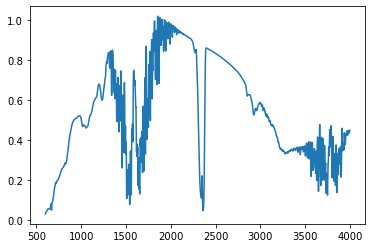

In [180]:
#Test Plot 
fig,ax = plt.subplots()
ax.plot(x, complete_nowavenumberindex_df.iloc[3][3:])

In [183]:
complete_nowavenumberindex_df.iloc[3]


region               1.000000
x coordinate      5702.126465
y coordinate      2015.540039
Wavenumber0          0.449126
Wavenumber1          0.445030
                     ...     
Wavenumber2376       0.039947
Wavenumber2377       0.038109
Wavenumber2378       0.036063
Wavenumber2379       0.033872
Wavenumber2380       0.031741
Name: 1, Length: 2384, dtype: float64

In [184]:
#test some math from actual FTIR script

#only show between 1715 and 1595
baseline_corrected_AmideI_df = pd.DataFrame()

sd_baseline_correction(complete_nowavenumberindex_df.iloc[1].transpose(),cols=[cols_], flip=False, method='rubberband', bounds=('Wavenumber500', 'Wavenumber600'))

# for cols_ in wnrawData_df.columns[1:]:
#     baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

# print(rawData_df.columns)

NameError: name 'cols_' is not defined

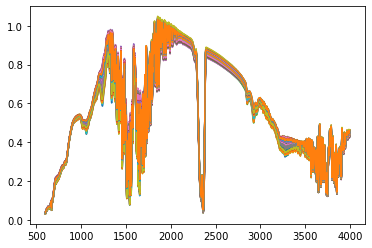

ValueError: x and y must have same first dimension, but have shapes (2381,) and (2383,)

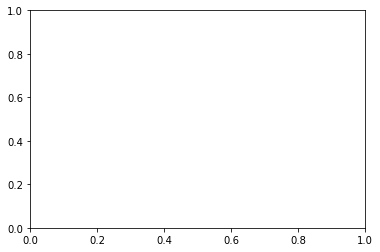

In [16]:

(complete_df.T).to_csv(r'C:\Users\jrosh\Documents\FTIR_Mapping\Results\test.csv')

x = [key for key in complete_df.keys() if type(key) == float]
complete_df[x]

fig, ax = plt.subplots()    # create figure and axes
for index, row in complete_df[x].iterrows(): 
    ax.plot(x, row)
plt.show()

plt.plot(x,complete_df.iloc[2][2:])

In [157]:
# complete_df.columns[2:]

In [160]:
# complete_df.iterrows()
# complete_df.iloc[3,:][2:]

In [159]:
# complete_df[3]

In [88]:
loc = list(map(float, complete_df.columns[2:]))


print(len(complete_df.columns[2:]))
print(len(loc))
print(complete_df.loc[1,[2:]])

fig, ax = plt.subplots()
for row in complete_df.iterrows():
    ax.scatter(row[1], loc, label=row[1].name)

plt.legend()    
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_18396/3602723537.py, line 5)

ValueError: x and y must be the same size

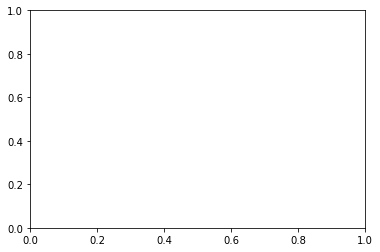

In [70]:
fig, ax = plt.subplots()
# for row in complete_df.iterrows():
#     ax.scatter(row[1], complete_df.columns[2:] , label=row[1].name)

ax.scatter(complete_df.iloc[1,:], complete_df.columns[2:] , label=row[1].name)
complete_df.iloc[1,:]

plt.legend()    
plt.show()

### Access loaded data and parameters:

In [ ]:
data.x                    # X coordinates
data.parameters['SNM']    # Sample name
data.description          # Description of data object
opusFC.paramDict['SNM']     # String description of SNM

### Access and save visible images:

In [ ]:
images = opusFC.getVisImages(f)

for img in images:
    data = img['image']
    title = img['Title']
    imgext = img['imgext']
    f = "{0}_{1}.{2}".format(f, title, imgext)
    with open(f, 'wb') as fd:
        fd.write(data)

In [ ]:
d_db = pd.DataFrame()
bt = tuple()
for things in dbs:
    print(opusFC.getOpusData(f,things))

In [ ]:
opusFC.MultiRegionTRCDataReturn(labels, regions, **kwds)